<a href="https://colab.research.google.com/github/justprophet/CarTrawler-Analysis/blob/master/code/CarTrawlerTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mounting Drive and Loading Data**

In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Importing Libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
sns.set()

**Loading the dataset**

In [0]:
data = pd.read_csv('gdrive/My Drive/job/Code/SampleData.txt', sep="|", header=None)
data.columns = ["queryID", "vehicleID", "queryDate", "nFeature1", "nFeature2", "priceOfCar", "nFeature3", "nFeature4", "nFeature5", "cFeature1", "cFeature2", "cFeature3", "nFeature6", "nFeature7", "nFeature8", "cFeature4", "nFeature9", "nFeature10", "nFeature11", "nQFeature1", "nQFeature2", "RentDuration", "PickUpDate", "nQFeature3", "Target" ]
data.head()

,queryID,vehicleID,queryDate,nFeature1,nFeature2,priceOfCar,nFeature3,nFeature4,nFeature5,cFeature1,cFeature2,cFeature3,nFeature6,nFeature7,nFeature8,cFeature4,nFeature9,nFeature10,nFeature11,nQFeature1,nQFeature2,RentDuration,PickUpDate,nQFeature3,Target
0,102120401529162609,1001396153,2017-01-02 12:04:01,2,1,750.26,2,1,1,5,1,7,1,0,8,8.0,385,3,1,1,2,14.0,2017-02-04 00:00:00,71,0
1,102120401529162609,401793302,2017-01-02 12:04:01,2,1,322.12,4,1,1,5,5,5,0,0,4,6.0,1368,3,0,1,2,14.0,2017-02-04 00:00:00,71,0
2,102120401529162609,2100312948,2017-01-02 12:04:01,1,1,466.38,1,1,2,5,5,5,1,0,4,7.0,1741,3,0,1,2,14.0,2017-02-04 00:00:00,71,0
3,102120401529162609,1697088827,2017-01-02 12:04:01,1,1,303.52,4,1,2,5,5,5,1,0,4,6.0,1912,3,0,1,2,14.0,2017-02-04 00:00:00,71,0
4,102120401529162609,682137395,2017-01-02 12:04:01,1,1,282.19,1,1,1,3,1,4,1,0,2,6.0,1960,3,0,1,2,14.0,2017-02-04 00:00:00,71,0


In [0]:
data.shape

(1108765, 25)

**Changing the type of Nominal Data since it will originally be assumed as Continous or Numerical Data Type**

In [0]:
data[['nFeature1', 'nFeature2', 'nFeature3', 'nFeature4', 'nFeature5', 'nFeature6', 'nFeature7', 'nFeature8', 'nFeature9', 'nFeature10', 'nFeature11']] = data[['nFeature1', 'nFeature2', 'nFeature3', 'nFeature4', 'nFeature5', 'nFeature6', 'nFeature7', 'nFeature8', 'nFeature9', 'nFeature10', 'nFeature11']].astype('category')
data[['nQFeature1', 'nQFeature2', 'nQFeature3']] = data[['nQFeature1', 'nQFeature2', 'nQFeature3']].astype('category')
data[['Target']] = data[['Target']].astype('category')

In [0]:
data.describe(include='all')

,queryID,vehicleID,queryDate,nFeature1,nFeature2,priceOfCar,nFeature3,nFeature4,nFeature5,cFeature1,cFeature2,cFeature3,nFeature6,nFeature7,nFeature8,cFeature4,nFeature9,nFeature10,nFeature11,nQFeature1,nQFeature2,RentDuration,PickUpDate,nQFeature3,Target
count,1.108765e+06,1.108765e+06,1108765,1108765.0,1108765.0,1.108765e+06,1108765.0,1108765.0,1108765.0,1.108765e+06,1.108765e+06,1.108765e+06,1108765.0,1108765.0,1108765.0,1.095568e+06,1108765.0,1108765.0,1108765.0,1108765.0,1108765.0,1.108765e+06,1108765,1108765.0,1108765.0
unique,NaN,NaN,4051,3.0,2.0,NaN,6.0,4.0,5.0,NaN,NaN,NaN,2.0,2.0,16.0,NaN,58.0,6.0,2.0,44.0,2.0,NaN,294,2.0,2.0
top,NaN,NaN,2017-01-09 23:39:41,1.0,1.0,NaN,1.0,1.0,1.0,NaN,NaN,NaN,1.0,0.0,3.0,NaN,1912.0,3.0,0.0,1.0,2.0,NaN,2017-04-08 00:00:00,71.0,0.0
freq,NaN,NaN,751,843985.0,1035728.0,NaN,584486.0,847073.0,875922.0,NaN,NaN,NaN,1063519.0,917235.0,208960.0,NaN,65534.0,1055656.0,861997.0,761759.0,692282.0,NaN,14693,692282.0,1104707.0
mean,2.881691e+16,1.072195e+09,NaN,NaN,NaN,6.278993e+02,NaN,NaN,NaN,4.531986e+00,2.841257e+00,5.215796e+00,NaN,NaN,NaN,6.827730e+00,NaN,NaN,NaN,NaN,NaN,9.322821e+00,NaN,NaN,NaN
std,4.649240e+16,6.231840e+08,NaN,NaN,NaN,6.351999e+02,NaN,NaN,NaN,8.189798e-01,1.432739e+00,1.115382e+00,NaN,NaN,NaN,8.699843e-01,NaN,NaN,NaN,NaN,NaN,5.445166e+00,NaN,NaN,NaN
min,3.114840e+14,3.918000e+03,NaN,NaN,NaN,1.591800e+02,NaN,NaN,NaN,2.000000e+00,0.000000e+00,2.000000e+00,NaN,NaN,NaN,4.000000e+00,NaN,NaN,NaN,NaN,NaN,1.000000e+00,NaN,NaN,NaN
25%,5.214847e+14,5.275361e+08,NaN,NaN,NaN,2.942000e+02,NaN,NaN,NaN,4.000000e+00,2.000000e+00,5.000000e+00,NaN,NaN,NaN,6.000000e+00,NaN,NaN,NaN,NaN,NaN,6.000000e+00,NaN,NaN,NaN
50%,8.114858e+14,1.072732e+09,NaN,NaN,NaN,4.364200e+02,NaN,NaN,NaN,5.000000e+00,3.000000e+00,5.000000e+00,NaN,NaN,NaN,7.000000e+00,NaN,NaN,NaN,NaN,NaN,7.000000e+00,NaN,NaN,NaN
75%,1.021232e+17,1.619128e+09,NaN,NaN,NaN,7.245900e+02,NaN,NaN,NaN,5.000000e+00,4.000000e+00,5.000000e+00,NaN,NaN,NaN,8.000000e+00,NaN,NaN,NaN,NaN,NaN,1.300000e+01,NaN,NaN,NaN


In [0]:
data.isna().any()

queryID         False
vehicleID       False
queryDate       False
nFeature1       False
nFeature2       False
priceOfCar      False
nFeature3       False
nFeature4       False
nFeature5       False
cFeature1       False
cFeature2       False
cFeature3       False
nFeature6       False
nFeature7       False
nFeature8       False
cFeature4        True
nFeature9       False
nFeature10      False
nFeature11      False
nQFeature1      False
nQFeature2      False
RentDuration    False
PickUpDate      False
nQFeature3      False
Target          False
dtype: bool

In [0]:
data = data.drop('cFeature4', axis = 1)

**Data Exploration**

In [0]:
data["Target"].value_counts()

0    1104707
1       4058
Name: Target, dtype: int64

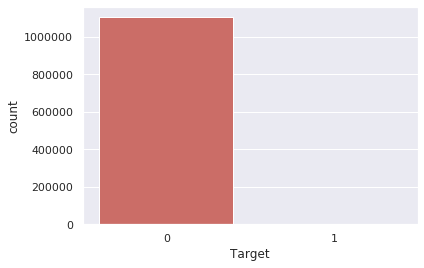

<Figure size 432x288 with 0 Axes>

In [0]:
sns.countplot(x='Target', data=data, palette='hls')
plt.show()
plt.savefig('count_plot')

In [0]:
count_no_booking = len(data[data['Target']==0])
count_booking = len(data[data['Target']==1])
pct_of_no_booking = count_no_booking/(count_no_booking+count_booking)
print("percentage of no booking is", pct_of_no_booking*100)
pct_of_booking = count_booking/(count_no_booking+count_booking)
print("percentage of booking", pct_of_booking*100)

percentage of no booking is 99.63400720621593
percentage of booking 0.36599279378407507


Our classes are imbalanced, and the ratio of no-booking to booking instances is 99.6:.37. Before we go ahead to balance the classes, let’s do some more exploration. 

In [0]:
data.groupby('Target').mean()

,queryID,vehicleID,priceOfCar,cFeature1,cFeature2,cFeature3,RentDuration
Target,,,,,,,
0,2.881767e+16,1.072042e+09,628.979331,4.531307,2.841947,5.216280,9.321484
1,2.860973e+16,1.113731e+09,333.881730,4.716609,2.653277,5.084032,9.686792


Observations:

1. The average number of customers who did the booking choose less priced cars. Will do some futher analysis on this. 

2. On an average, continous Feature1 and continous Feature4 are higher when it comes to selection of cars, where as continous feature 2 and 3 are lower. 

3. Rent duration for booked cars is higher. 


Since I know my data is very highly imbalanced, I am going to use undersampling to handle data

In [0]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

In [0]:
# Separate input features and target
y = data.Target
X = data.drop('Target', axis=1)

In [0]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27)

In [0]:
# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_booked = X[X.Target==0]
booked = X[X.Target==1]

In [0]:
# downsample majority
not_booked_downsampled = resample(not_booked,
                                replace = False, # sample without replacement
                                n_samples = len(booked), # match minority n
                                random_state = 27) # reproducible results

In [0]:
# combine minority and downsampled majority
downsampled = pd.concat([not_booked_downsampled, booked])

In [0]:
# checking counts
downsampled.Target.value_counts()

1    3061
0    3061
Name: Target, dtype: int64



Next, we will take help of some visualizations to see what categorical variables can be useful for prediction of our data

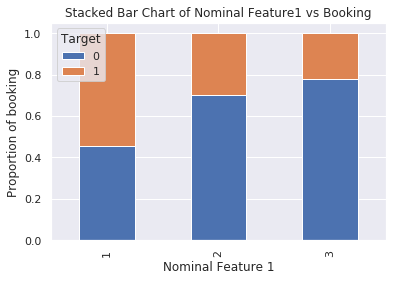

In [0]:
table=pd.crosstab(downsampled.nFeature1,downsampled.Target)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Nominal Feature1 vs Booking')
plt.xlabel('Nominal Feature 1')
plt.ylabel('Proportion of booking')
plt.savefig('nFeature1_vs_book')

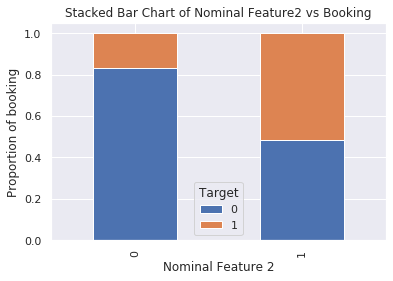

In [0]:
table=pd.crosstab(downsampled.nFeature2,downsampled.Target)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Nominal Feature2 vs Booking')
plt.xlabel('Nominal Feature 2')
plt.ylabel('Proportion of booking')
plt.savefig('nFeature2_vs_book')

While analysing these graphs, all the categorical variables seem important at the initial stage. Therefore I am going to skip this approach.

**We will first try to analyse and solve question 2 i.e. whether price has an influence on the customer's purchasing behavior. **

**Let's first Plot the data between two variables**

In [0]:
y = downsampled['Target']
x1 = downsampled['priceOfCar']

**Scatter Plot**

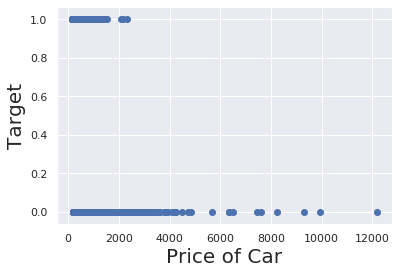

In [0]:
plt.scatter(x1,y)
plt.xlabel('Price of Car', fontsize=20)
plt.ylabel('Target', fontsize=20)
plt.show()

From the scatter plot, the initial analysis is that if we solely look on the price, cheaper cars seem to have more chance of being picked. 
We are going to use Logistic Regression technique to determine the relation between the two variables. 

**Regression**

In [0]:
x = sm.add_constant(x1)
reg_log = sm.Logit(y,x)
results_log = reg_log.fit()

Optimization terminated successfully.
         Current function value: 0.601130
         Iterations 7


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [0]:
results_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Target   No. Observations:                 6122
Model:                          Logit   Df Residuals:                     6120
Method:                           MLE   Df Model:                            1
Date:                Fri, 24 Jan 2020   Pseudo R-squ.:                  0.1328
Time:                        10:08:23   Log-Likelihood:                -3680.1
converged:                       True   LL-Null:                       -4243.4
Covariance Type:            nonrobust   LLR p-value:                5.304e-247
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5248      0.062     24.688      0.000       1.404       1.646
priceOfCar    -0.0036      0.000    -24.919      0.000      -0.004      -0.003
==============================================================================
"""

**Analysis of Summary**
1. This method uses MLE to determine the relationship and dependance between two variables. MLE tries to maximize Log-Likelihood.
2. The bigger the value of Log-Likelihood the better
3. The 'LL Null' is the log likelihood of a model which has no independant variables. 
4. Now to check if our model is significant we have LLR p-value (Log Likelihood Ration test). If the p-value is verly low which as we can see is actually 0.000 our model is significant. 



**Accuracy**

In [0]:
np.set_printoptions(formatter={"float" : lambda x: "{0:0.2f}".format(x)})
results_log.predict()

array([0.39, 0.02, 0.40, ..., 0.49, 0.67, 0.71])

In [0]:
np.array(data['Target'])

array([0, 0, 0, ..., 0, 0, 0])

In [0]:
results_log.pred_table()

array([[1601.00, 1460.00],
       [660.00, 2401.00]])

**Validation with Confusion Matrix**

In [0]:
cm_df = pd.DataFrame(results_log.pred_table())
cm_df.columns = ['Predicted 0', 'Predicted 1']
cm_df = cm_df.rename(index= {0: 'Actual 0', 1: 'Actual 1'})
cm_df

,Predicted 0,Predicted 1
Actual 0,1601.0,1460.0
Actual 1,660.0,2401.0


In [0]:
cm = np.array(cm_df)
accuracy_train = (cm[0,0] + cm[1,1])/cm.sum()
accuracy_train

0.6537079385821627

Now accroding to this we could say that model is 65.3% accurate

So pricing alone is not very signficant. 

#Analysis of Other Parameters in addition to price

In [0]:
# Separate input features and target
os_data_y = downsampled['Target']
os_data_x = downsampled.drop(['Target', 'queryDate', 'vehicleID', 'PickUpDate', 'queryID'] , axis=1)
os_data_x.head(1)

,nFeature1,nFeature2,priceOfCar,nFeature3,nFeature4,nFeature5,cFeature1,cFeature2,cFeature3,nFeature6,nFeature7,nFeature8,nFeature9,nFeature10,nFeature11,nQFeature1,nQFeature2,RentDuration,nQFeature3
609627,1,1,550.14,1,1,1,5,2,5,1,0,2,505,3,0,2,1,14.0,2492


Using Recursive Feature Elimination to check if can decrease some variables

In [0]:
data_final_vars=downsampled.columns.values.tolist()
y=['y']
X=[i for i in data_final_vars if i not in y]
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_x, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Categorical.ravel will return a Categorical object instead of an ndarray in a future version.
  
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


So, this method is not able to remove any of the features. 

Now, I am going to treat Continous and Categorical variables differently due to time contraints. First and foremost I will check for correlation between continous variables. 
**If there is a high correlation(either -ve or +ve) between two columns I will remove either of the two columns.**

In [0]:
downsampled.corr(method ='pearson') 

,queryID,vehicleID,priceOfCar,cFeature1,cFeature2,cFeature3,RentDuration
queryID,1.000000,0.020366,-0.000238,-0.008459,-0.009045,-0.009724,0.004263
vehicleID,0.020366,1.000000,-0.015180,0.011063,-0.025251,-0.013151,-0.008601
priceOfCar,-0.000238,-0.015180,1.000000,-0.033846,0.186822,0.180523,0.332663
cFeature1,-0.008459,0.011063,-0.033846,1.000000,0.284926,0.362970,0.040983
cFeature2,-0.009045,-0.025251,0.186822,0.284926,1.000000,0.248507,-0.007481
cFeature3,-0.009724,-0.013151,0.180523,0.362970,0.248507,1.000000,-0.029985
RentDuration,0.004263,-0.008601,0.332663,0.040983,-0.007481,-0.029985,1.000000


Since we can see that, no high correlation exist between any two variables we are going to apply regression to check the importance of continous variables. 

**The code is going to be the same as for pricing.**

In [0]:
y_check = downsampled['Target']
x2 = downsampled[['cFeature1', 'cFeature2', 'cFeature3','RentDuration', 'priceOfCar']]

In [0]:
x_check = sm.add_constant(x2)
reg_log_2 = sm.Logit(y_check,x_check)
results_log_2 = reg_log.fit()

Optimization terminated successfully.
         Current function value: 0.601130
         Iterations 7


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [0]:
results_log_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Target   No. Observations:                 6122
Model:                          Logit   Df Residuals:                     6120
Method:                           MLE   Df Model:                            1
Date:                Fri, 24 Jan 2020   Pseudo R-squ.:                  0.1328
Time:                        11:12:40   Log-Likelihood:                -3680.1
converged:                       True   LL-Null:                       -4243.4
Covariance Type:            nonrobust   LLR p-value:                5.304e-247
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5248      0.062     24.688      0.000       1.404       1.646
priceOfCar    -0.0036      0.000    -24.919      0.000      -0.004      -0.003
==============================================================================
"""

In [0]:
np.set_printoptions(formatter={"float" : lambda x: "{0:0.2f}".format(x)})
results_log_2.predict()
np.array(data['Target'])
results_log_2.pred_table()

array([[1601.00, 1460.00],
       [660.00, 2401.00]])

Analysis:

Althought initially from the results_log it seems that continous variables might be having an impact on the data but when plotting the confusion matrix the results are same.


#**Observing Categorical Features**



Now, there are a lot of Categorical(Nominal) variables in this dataset, of which we have no theoritical understanding. Also, it is not possible to find correlation between these variable. 

We can use a Deep Learning here and insert all categorical variables to get a model that predicts target. 


In [0]:
downsampled.columns

Index(['queryID', 'vehicleID', 'queryDate', 'nFeature1', 'nFeature2',
       'priceOfCar', 'nFeature3', 'nFeature4', 'nFeature5', 'cFeature1',
       'cFeature2', 'cFeature3', 'nFeature6', 'nFeature7', 'nFeature8',
       'nFeature9', 'nFeature10', 'nFeature11', 'nQFeature1', 'nQFeature2',
       'RentDuration', 'PickUpDate', 'nQFeature3', 'Target'],
      dtype='object')

In [0]:
data_categorical = downsampled[['nFeature1','nFeature2',
        'nFeature3', 'nFeature4', 'nFeature5', 'nFeature6', 'nFeature7', 'nFeature8',
       'nFeature9', 'nFeature10', 'nFeature11', 'nQFeature1', 'nQFeature2','nQFeature3']].to_numpy()

In [0]:
data_categorical

array([[1, 1, 1, ..., 2, 1, 2492],
       [1, 1, 11, ..., 1, 2, 71],
       [2, 0, 2, ..., 1, 1, 2492],
       ...,
       [1, 1, 2, ..., 1, 2, 71],
       [1, 1, 4, ..., 1, 2, 71],
       [1, 1, 1, ..., 1, 2, 71]], dtype=object)

Splitting the data in Train and Test

In [0]:
Y=downsampled[['Target']].values  #targets
X=data_categorical #input

In [0]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42) # random state for reproducability

In [0]:
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)

X_train (4897, 14)
X_test (1225, 14)
Y_train (4897, 1)
Y_test (1225, 1)


# Construction of Neural Networks

In [0]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

In [0]:
n_cols = X_train.shape[1]
n_cols

14

In [0]:
# Save the number of columns in predictors: n_cols


# Set up the model: model
model = Sequential()

In [0]:
# Add the first layer
model.add(Dense(100, activation='relu', input_shape=(n_cols,)))

In [0]:
# Add the second layer
model.add(Dense(100, activation='relu'))

In [0]:
# Add the output layer
model.add(Dense(1, activation='sigmoid'))

In [0]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
   
# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(patience=2)
    
# Fit the model
#model.fit(X_train,Y_train,epochs=20,validation_data=(X_test,Y_test))
# Fit the model
history=model.fit(X_train, Y_train, validation_split=0.3, epochs=30,  callbacks= [early_stopping_monitor])

Train on 3427 samples, validate on 1470 samples
Epoch 1/30
3427/3427 [==============================] - 1s 233us/step - loss: 0.6506 - acc: 0.6078 - val_loss: 0.6437 - val_acc: 0.5878
Epoch 2/30
3427/3427 [==============================] - 0s 140us/step - loss: 0.6570 - acc: 0.5947 - val_loss: 0.6424 - val_acc: 0.6197
Epoch 3/30
3427/3427 [==============================] - 0s 139us/step - loss: 0.6517 - acc: 0.6040 - val_loss: 0.6409 - val_acc: 0.6218
Epoch 4/30
3427/3427 [==============================] - 1s 149us/step - loss: 0.6619 - acc: 0.5897 - val_loss: 0.6394 - val_acc: 0.6197
Epoch 5/30
3427/3427 [==============================] - 0s 128us/step - loss: 0.6512 - acc: 0.6067 - val_loss: 0.6392 - val_acc: 0.6197
Epoch 6/30
3427/3427 [==============================] - 0s 139us/step - loss: 0.6526 - acc: 0.6069 - val_loss: 0.6403 - val_acc: 0.6204
Epoch 7/30
3427/3427 [==============================] - 0s 133us/step - loss: 0.6530 - acc: 0.6064 - val_loss: 0.6432 - val_acc: 0.6204


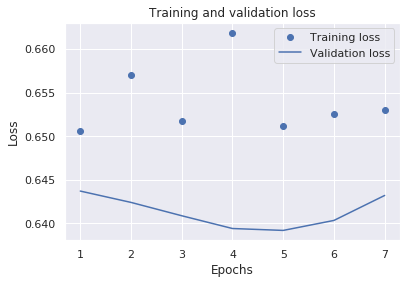

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(loss)+1)

plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'b',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [0]:
y_pred=model.predict(X_test)
y_pred =(y_pred>0.5)
print(y_pred)

[[False]
 [False]
 [False]
 ...
 [False]
 [ True]
 [False]]


In [0]:
from sklearn.metrics import confusion_matrix
cm_2 = confusion_matrix(Y_test, y_pred)
print(cm_2)

[[502 122]
 [331 270]]


In [0]:
cm = np.array(cm_2)
accuracy_train = (cm[0,0] + cm[1,1])/cm.sum()
accuracy_train

0.6302040816326531